# Unit 17 - 進階案例研究：CSTR 連續反應槽產品質量預測
## CSTR Continuous Product Quality Prediction with Sequence-to-Sequence Model (Encoder-Decoder Model)

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit17_RNN_Seq2Seq'
SOURCE_DATA_DIR = 'cstr_simulation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4' / 'Unit17'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\data\cstr_simulation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_RNN_Seq2Seq
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_RNN_Seq2Seq\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_RNN_Seq2Seq\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import joblib, pickle, json
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow / Keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, 
    RepeatVector, TimeDistributed, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow版本: {tf.__version__}")
print(f"Keras版本: {keras.__version__}")

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 設定matplotlib中文顯示
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial'] # Colab不支援
plt.rcParams['axes.unicode_minus'] = False

TensorFlow版本: 2.10.1
Keras版本: 2.10.0


## 2. CSTR 非線性動態模擬器

### 🏭 製程模型說明

我們建立一個**簡化的 CSTR 動態模型**，專門設計來展示 Seq2Seq 模型的優勢：

**反應方程**：A → B (一階不可逆反應)

**物質平衡** (標準 CSTR):
$$\frac{dC_A}{dt} = \frac{F}{V}(C_{Af} - C_A) - k(T) \cdot C_A$$

$$\frac{dC_B}{dt} = \frac{F}{V}(-C_B) + k(T) \cdot C_A$$

**溫度動態** (簡化模型):
$$\frac{dT}{dt} = \frac{T_{target} - T}{\tau}$$

**反應速率常數** (Arrhenius):
$$k(T) = k_0 \exp\left(-\frac{E_a}{R T}\right)$$


In [3]:
def simulate_cstr_nonlinear(
    total_hours=1000,
    dt=1.0,  # 時間步長 (分鐘)
    F_base=2.0,  # 基準進料流量 m³/h
    Tc_base=300.0,  # 基準冷卻水溫度 K
    CAf_base=2000.0,  # 基準進料濃度 mol/m³
    noise_level=0.5,  # 噪聲強度
    seed=42
):
    """
    模擬 CSTR 非線性動態系統 (Seq2Seq 優化版 v6 - 簡化版)
    
    🎯 核心策略：簡化能量平衡，突出Tc的作用
    - 使用簡化的溫度動態模型
    - 溫度主要受三個因素影響：
      1. 冷卻水溫度 Tc (直接影響)
      2. 反應放熱 (受CAf和當前溫度影響)
      3. 進料帶入熱 (受F影響)
    
    操縱變數 MV (3個):
        F: 進料流量 (m³/h)
        T_c: 冷卻水溫度 (K) - 主要控制手段
        C_Af: 進料濃度 (mol/m³)
    
    觀測變數 PV (3個):
        C_A: 槽內反應物濃度 (mol/m³)
        T: 槽內溫度 (K) - 強依賴Tc
        C_B: 產物濃度 (mol/m³)
    
    品質變數 QV (1個):
        G: 某個關鍵特性指標 = f(C_A, C_B, T, x1_dot, x2_dot), 其中 x1_dot, x2_dot 為 隱藏狀態

    可額外觀察:
        X: 轉化率 = (C_Af - C_A) / C_Af × 100 (%)
        Purity: 純度 = C_B / (C_A + C_B + 1e-6) × 100 (%)

    """
    np.random.seed(seed)
    
    # ===== 物理參數 (簡化版) =====
    V = 3.0          # 反應槽體積 m³
    tau = 90.0       # 🔥 溫度時間常數 (分鐘) - 控制動態響應速度
    rho = 1000.0     # 密度 kg/m³
    Cp = 4.18        # 熱容 kJ/(kg·K)
    k0 = 1.0e7       # 指前因子 1/min
    Ea = 50000.0     # 活化能 J/mol
    R = 8.314        # 氣體常數 J/(mol·K)
    Tf = 298.0       # 進料溫度 K
    
    # 溫度動態參數（簡化模型）
    alpha_Tc = 0.70  # 🔥 Tc對T的影響權重 (0.7 表示T會跟隨Tc變化70%)
    alpha_rxn = 0.25 # 🔥 反應放熱的影響權重
    alpha_F = 0.05   # 🔥 進料流量的影響權重
    
    # 時間設定 (分鐘)
    dt_min = dt
    n_steps = int(total_hours * 60 / dt_min)
    time_min = np.arange(n_steps) * dt_min
    
    # ===== 操縱變數生成 (階躍變化) =====
    F = np.ones(n_steps) * F_base
    Tc = np.ones(n_steps) * Tc_base
    CAf = np.ones(n_steps) * CAf_base
    
    # 階躍變化間隔：6小時
    change_interval = 1440  
    n_changes = n_steps // change_interval

    # 假設 F, Tc, CAf 有10種操作組合的規格
    specs = [
        (1.6, 290.0, 1500.0),
        (1.8, 295.0, 1750.0),
        (2.0, 300.0, 2000.0),
        (2.2, 305.0, 2250.0),
        (2.4, 310.0, 2500.0),
        (1.7, 292.0, 1600.0),
        (1.9, 297.0, 1850.0),
        (2.1, 302.0, 2100.0),
        (2.3, 307.0, 2350.0),
        (2.5, 312.0, 2600.0),
    ]
    
    for i in range(n_changes):
        start_idx = i * change_interval
        end_idx = min((i+1) * change_interval, n_steps)
        
        # 從 specs 中隨機選擇一組規格
        spec = specs[np.random.randint(len(specs))]
        F[start_idx:end_idx] = spec[0]
        Tc[start_idx:end_idx] = spec[1]
        CAf[start_idx:end_idx] = spec[2]
            
    # 添加小幅隨機波動
    F += np.random.normal(0, 0.02*noise_level, n_steps)
    Tc += np.random.normal(0, 0.3*noise_level, n_steps)
    CAf += np.random.normal(0, 5*noise_level, n_steps)
    
    # ===== 狀態變數初始化 =====
    CA = np.zeros(n_steps)
    T = np.zeros(n_steps)
    CB = np.zeros(n_steps)

    # 非線性隱藏狀態參數
    a1, a2 = 0.08, 0.05
    b11, b12 = 0.25, -0.15
    b21, b22 = 0.10, -0.30
    c11, c12 = 0.18, 0.10
    c21, c22 = 0.05, 0.12
    x1_dot = np.zeros(n_steps)  # 隱藏狀態 1
    x2_dot = np.zeros(n_steps)  # 隱藏狀態 2
    
    # 初始穩態
    CA[0] = 1800.0
    T[0] = 300.0
    CB[0] = 200.0
    
    # ===== 動態模擬 =====
    for i in range(n_steps - 1):
        ca = CA[i]
        t_current = T[i]
        cb = CB[i]
        
        # 反應速率
        k = k0 * np.exp(-Ea / (R * t_current))
        r_A = k * ca
        
        # 物質平衡（標準CSTR）
        dCA_dt = (F[i]/V) * (CAf[i] - ca) - r_A
        dCB_dt = (F[i]/V) * (0 - cb) + r_A
        
        # 🔥 簡化的溫度動態模型
        # T的目標值 = Tc的加權平均 + 反應放熱貢獻 + 進料溫度影響
        T_target = (alpha_Tc * Tc[i] + 
                   alpha_rxn * (t_current + r_A * 0.002) +  # 反應放熱使溫度上升
                   alpha_F * (Tf + (2.5 - F[i]) * 2.0))    # 流量影響
        
        # 一階動態響應（時間常數tau）
        dT_dt = (T_target - t_current) / tau
        
        # 歐拉積分
        CA[i+1] = ca + dCA_dt * dt_min
        CB[i+1] = cb + dCB_dt * dt_min
        T[i+1] = t_current + dT_dt * dt_min

        # 隱藏狀態
        nl1 = 0.04 * np.tanh(x1_dot[i] * x2_dot[i])
        nl2 = - 0.03 * np.tanh((x2_dot[i] ** 2))
        dx1 = -a1 * x1_dot[i] + b11 * CA[i] + b12 * CB[i] + c11 * T[i] + nl1
        dx2 = -a2 * x2_dot[i] + b21 * CA[i] + b22 * CB[i] + c21 * T[i] + nl2
        x1_dot[i+1] = x1_dot[i] + dt_min * dx1
        x2_dot[i+1] = x2_dot[i] + dt_min * dx2
        
        # 添加過程噪聲 (小幅)
        # CA[i+1] += np.random.normal(0, 5*noise_level)
        # CB[i+1] += np.random.normal(0, 3*noise_level)
        # T[i+1] += np.random.normal(0, 0.5*noise_level)
    
    # 確保物理合理性
    CA = np.clip(CA, 0, 5000)
    CB = np.clip(CB, 0, 5000)
    T = np.clip(T, 280, 350)
    
    # ===== 額外觀察計算 =====
    # 轉化率 (%)
    X = (CAf - CA) / (CAf + 1e-6) * 100.0
    X = np.clip(X, 0, 100)
    
    # 純度 (%)
    Purity = CB / (CA + CB + 1e-6) * 100.0
    Purity = np.clip(Purity, 0, 100)

    # 某個關鍵特性指標 G (非線性函數)
    G = (0.5 * X + 0.3 * Purity +
         10.0 * np.sqrt(x1_dot) +
         8.0 * np.sqrt(x2_dot))
    
    # ===== 疊加量測噪聲 =====
    CA_measured = CA + np.random.normal(0, 8*noise_level, n_steps)
    T_measured = T + np.random.normal(0, 1.0*noise_level, n_steps)
    CB_measured = CB + np.random.normal(0, 5*noise_level, n_steps)
    X_measured = X #+ np.random.normal(0, 1.5*noise_level, n_steps)
    Purity_measured = Purity #+ np.random.normal(0, 1.0*noise_level, n_steps)
    
    # ===== 建立 DataFrame =====
    df = pd.DataFrame({
        'time_min': time_min,
        'time_hour': time_min / 60.0,
        # 操縱變數 (U)
        'U_F': F,
        'U_Tc': Tc,
        'U_CAf': CAf,
        # 真實狀態
        'Y_CA_true': CA,
        'Y_T_true': T,
        'Y_CB_true': CB,
        # 觀測變數 (Y, 含噪聲)
        'Y_CA': CA_measured,
        'Y_T': T_measured,
        'Y_CB': CB_measured,
        # 品質變數 (Q, 含噪聲)
        'Q_X': X_measured,
        'Q_Purity': Purity_measured,
        # 真實品質
        'Q_X_true': X,
        'Q_Purity_true': Purity,
        'G': G
    })
    
    return df

## 3. 數據生成與探索性分析

In [4]:
# 生成模擬數據
print("開始生成 CSTR 模擬數據...")
df_sim = simulate_cstr_nonlinear(
    total_hours=1000,  # 1000 小時
    dt=1.0,            # 1 分鐘採樣
    noise_level=0.1,   # 只保留測量噪聲
    seed=42
)

print(f"\n數據集形狀: {df_sim.shape}")
print(f"時間範圍: {df_sim['time_hour'].min():.1f} ~ {df_sim['time_hour'].max():.1f} 小時")
print(f"\n數據摘要:\n{df_sim.describe()}")

開始生成 CSTR 模擬數據...

數據集形狀: (60000, 16)
時間範圍: 0.0 ~ 1000.0 小時

數據摘要:
           time_min     time_hour           U_F          U_Tc         U_CAf  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean   29999.500000    499.991667      2.084000    301.848126   2092.400795   
std    17320.652413    288.677540      0.257190      6.437709    321.879036   
min        0.000000      0.000000      1.593321    289.906989   1498.353706   
25%    14999.750000    249.995833      1.899534    296.992820   1849.874679   
50%    29999.500000    499.991667      2.098554    301.977955   2099.626622   
75%    44999.250000    749.987500      2.300795    307.011553   2350.186938   
max    59999.000000    999.983333      2.507205    312.110836   2601.828483   

          Y_CA_true      Y_T_true     Y_CB_true          Y_CA           Y_T  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean    2024.047268    301.680195     68.412797   2024.045514  

### 3.1 視覺化製程動態

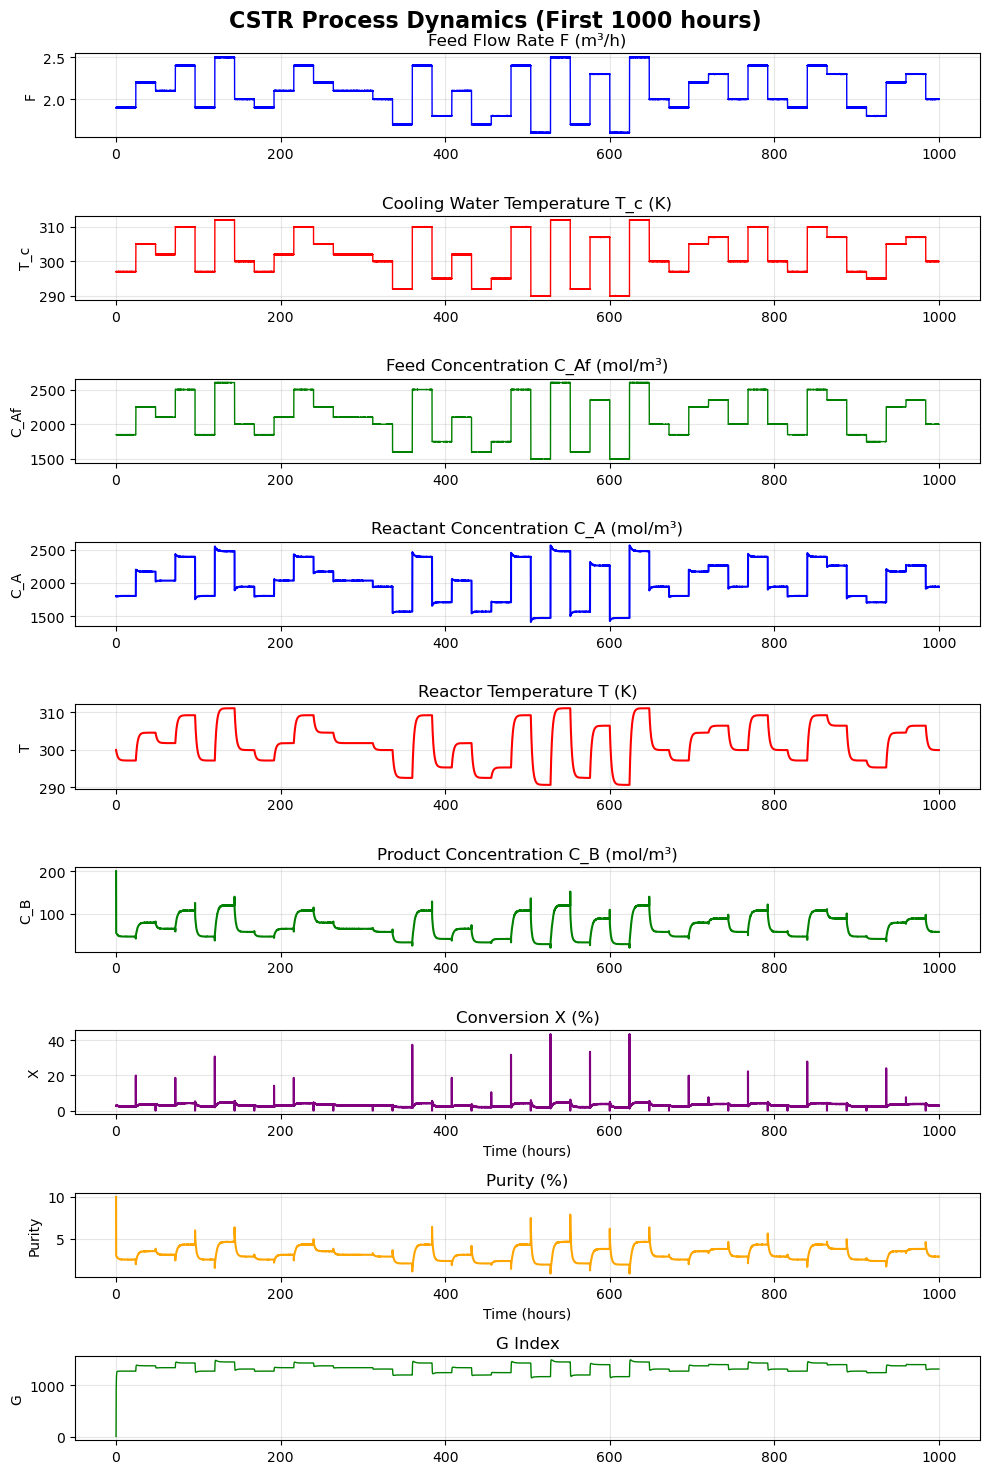

In [5]:
# 繪製前 100 小時的製程動態
plot_hours = 1000
plot_data = df_sim[df_sim['time_hour'] <= plot_hours]

fig, axes = plt.subplots(9, 1, figsize=(10, 15))
fig.suptitle(f'CSTR Process Dynamics (First {plot_hours} hours)', fontsize=16, fontweight='bold')


# Manipulated Variables
axes[0].plot(plot_data['time_hour'], plot_data['U_F'], 'b-', linewidth=1)
axes[0].set_title('Feed Flow Rate F (m³/h)')
axes[0].set_ylabel('F')
axes[0].grid(alpha=0.3)

axes[1].plot(plot_data['time_hour'], plot_data['U_Tc'], 'r-', linewidth=1)
axes[1].set_title('Cooling Water Temperature T_c (K)')
axes[1].set_ylabel('T_c')
axes[1].grid(alpha=0.3)

axes[2].plot(plot_data['time_hour'], plot_data['U_CAf'], 'g-', linewidth=1)
axes[2].set_title('Feed Concentration C_Af (mol/m³)')
axes[2].set_ylabel('C_Af')
axes[2].grid(alpha=0.3)

# Process Variables (True vs Measured)
axes[3].plot(plot_data['time_hour'], plot_data['Y_CA_true'], 'b-', linewidth=1.5, label='True')
axes[3].set_title('Reactant Concentration C_A (mol/m³)')
axes[3].set_ylabel('C_A')
axes[3].grid(alpha=0.3)

axes[4].plot(plot_data['time_hour'], plot_data['Y_T_true'], 'r-', linewidth=1.5, label='True')
axes[4].set_title('Reactor Temperature T (K)')
axes[4].set_ylabel('T')
axes[4].grid(alpha=0.3)

axes[5].plot(plot_data['time_hour'], plot_data['Y_CB_true'], 'g-', linewidth=1.5, label='True')
axes[5].set_title('Product Concentration C_B (mol/m³)')
axes[5].set_ylabel('C_B')
axes[5].grid(alpha=0.3)

# Quality Variables
axes[6].plot(plot_data['time_hour'], plot_data['Q_X_true'], 'purple', linewidth=1.5, label='True')
axes[6].set_title('Conversion X (%)')
axes[6].set_ylabel('X')
axes[6].set_xlabel('Time (hours)')
axes[6].grid(alpha=0.3)

axes[7].plot(plot_data['time_hour'], plot_data['Q_Purity_true'], 'orange', linewidth=1.5, label='True')
axes[7].set_title('Purity (%)')
axes[7].set_ylabel('Purity')
axes[7].set_xlabel('Time (hours)')
axes[7].grid(alpha=0.3)

axes[8].plot(plot_data['time_hour'], plot_data['G'], 'g-', linewidth=1)
axes[8].set_title('G Index')
axes[8].set_ylabel('G')
axes[8].grid(alpha=0.3)

# 相平面圖
# axes[2, 2].scatter(plot_data['Y_CA'], plot_data['Y_T'], c=plot_data['time_hour'], 
#                    cmap='viridis', s=1, alpha=0.5)
# axes[2, 2].set_title('相平面圖 (C_A vs T)')
# axes[2, 2].set_xlabel('C_A (mol/m³)')
# axes[2, 2].set_ylabel('T (K)')
# axes[2, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'cstr_process_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Encoder-Deoder 數據準備

**在Decoder部分我們採用Autoregrasive機制, 需注意數據準備工作**

### 📦 Seq2Seq 窗口設計

**實際數據維度**：
- 總樣本數：5988
- 訓練集：4191 樣本 (70%)
- 驗證集：898 樣本 (15%)
- 測試集：899 樣本 (15%)

**Encoder 輸入**（過去）：
- 特徵：MV (3個) + PV (3個) = 6 個特徵
- 時間窗口：過去 W 步（例如 90 步 = 90 分鐘）, `[t, t-1, t-2, ..., t-W+1]`
- 變數名稱：`X_enc` 
- 形狀：`(batch, W, 6)`

**Decoder 輸入**（未來）：
- 特徵：MV (3個)（未來的操控計劃）
- 時間窗口：未來 H 步（例如 30 步 = 30 分鐘）, `[t+1, t+2, ..., t+H]`
- 變數名稱：`X_dec_u` 
- 形狀：`(batch, H, 3)`

**Decoder 初始值**：
- 特徵： PV (3個) = 3 個特徵
- 時間窗口：當前`t`時刻的輸出, `[t]`
- 變數名稱：`y_init` 
- 形狀：`(batch, 3)`

**Decoder 輸出**（未來）：
- 特徵：Y (3個) + Q (1個) = 4 個特徵
- 時間窗口：未來 H 步, `[t+1, t+2, ..., t+H]`
- 變數名稱：`y` 
- 形狀：`(batch, H, 4)`

In [6]:
def create_seq2seq_dataset(df, 
                           encoder_steps=90,   # 過去 90 分鐘
                           decoder_steps=30,   # 未來 30 分鐘
                           window=1,           # 滑動窗口長度（用於平滑數據）
                           shift=1,            # 取樣間隔（步進）
                           train_ratio=0.7,
                           val_ratio=0.15):
    """
    建立 Seq2Seq 數據集（自回歸版本，支援 Scheduled Sampling）
    
    🔥 關鍵變化：
    - Decoder 輸入包含：U(t) + Y(t-1) + Q(t-1)
    - 第一步使用 encoder 最後時刻的輸出作為初始值
    - 訓練時支援 teacher forcing（使用真實值）
    
    參數：
        window: 滑動窗口長度（默認=1，不平滑）。
                若 window > 1，則對數據進行滑動窗口平均處理以減少噪聲。
                例如 window=5 表示每個時刻取前5個時刻的平均值。
        shift: 取樣間隔（默認=1，連續取樣）。
               若 shift > 1，則每隔 shift 個時間步創建一個樣本。
               例如 shift=5 表示每隔5分鐘創建一個訓練樣本（減少樣本數量，增加獨立性）。
    
    Returns:
        X_enc_train, X_dec_u_train, y_train, y_init_train,
        X_enc_val, X_dec_u_val, y_val, y_init_val,
        X_enc_test, X_dec_u_test, y_test, y_init_test,
        scalers
    """
    # 特徵選擇
    U_cols = ['U_F', 'U_Tc', 'U_CAf']  # 操縱變數 (3個)
    Y_cols = ['Y_CA', 'Y_T', 'Y_CB']   # 觀測變數 (3個)
    Q_cols = ['G']                      # 品質變數 (1個)
    
    encoder_input_cols = U_cols + Y_cols  # 6 個
    decoder_input_cols = U_cols           # 3 個（操縱變數）
    decoder_output_cols = Y_cols + Q_cols # 4 個（觀測+品質）
    
    # 提取所有需要的欄位（保持穩定順序）
    all_cols = list(dict.fromkeys(encoder_input_cols + decoder_output_cols))
    df_use = df[all_cols].copy()
    
    # 🔥 應用滑動窗口平滑（若 window > 1）
    if window > 1:
        print(f"應用滑動窗口平滑（窗口長度={window}）...")
        df_use = df_use.rolling(window=window, min_periods=1, center=False).mean()

    def _build_sequences():
        X_encoder = []      # (N, encoder_steps, 6)
        X_decoder_U = []    # (N, decoder_steps, 3) - 未來操縱變數
        Y_decoder = []      # (N, decoder_steps, 4) - 未來真實輸出（用於teacher forcing）
        Y_init = []         # (N, 3) - decoder 初始輸出（編碼器最後時刻的輸出）

        n_total = len(df_use)
        for i in range(encoder_steps, n_total - decoder_steps, shift):
            enc_seq = df_use.iloc[i - encoder_steps:i][encoder_input_cols].values
            dec_u_seq = df_use.iloc[i:i + decoder_steps][decoder_input_cols].values
            dec_out_seq = df_use.iloc[i:i + decoder_steps][decoder_output_cols].values
            y_init_val = df_use.iloc[i - 1][Y_cols].values

            X_encoder.append(enc_seq)
            X_decoder_U.append(dec_u_seq)
            Y_decoder.append(dec_out_seq)
            Y_init.append(y_init_val)

        return (np.array(X_encoder), np.array(X_decoder_U),
                np.array(Y_decoder), np.array(Y_init))

    X_encoder, X_decoder_U, Y_decoder, Y_init = _build_sequences()

    print(f"X_encoder shape: {X_encoder.shape}")
    print(f"X_decoder_U shape: {X_decoder_U.shape}")
    print(f"Y_decoder shape: {Y_decoder.shape}")
    print(f"Y_init shape: {Y_init.shape}")

    # 時間序列劃分
    n_samples = X_encoder.shape[0]
    train_idx = int(n_samples * train_ratio)
    val_idx = int(n_samples * (train_ratio + val_ratio))

    X_enc_train = X_encoder[:train_idx]
    X_dec_u_train = X_decoder_U[:train_idx]
    y_train = Y_decoder[:train_idx]
    y_init_train = Y_init[:train_idx]

    X_enc_val = X_encoder[train_idx:val_idx]
    X_dec_u_val = X_decoder_U[train_idx:val_idx]
    y_val = Y_decoder[train_idx:val_idx]
    y_init_val = Y_init[train_idx:val_idx]

    X_enc_test = X_encoder[val_idx:]
    X_dec_u_test = X_decoder_U[val_idx:]
    y_test = Y_decoder[val_idx:]
    y_init_test = Y_init[val_idx:]

    def _fit_scalers(X_enc, X_dec_u, y):
        scaler_U = StandardScaler()
        scaler_Y = StandardScaler()
        scaler_Q = StandardScaler()

        U_train_enc = X_enc[:, :, :3].reshape(-1, 3)
        Y_train_enc = X_enc[:, :, 3:].reshape(-1, 3)
        Q_train_out = y[:, :, 3:].reshape(-1, 1)

        scaler_U.fit(U_train_enc)
        scaler_Y.fit(Y_train_enc)
        scaler_Q.fit(Q_train_out)

        return {'U': scaler_U, 'Y': scaler_Y, 'Q': scaler_Q}

    def _apply_scalers(X_enc, X_dec_u, y, y_init, scalers):
        X_enc = X_enc.copy()
        X_dec_u = X_dec_u.copy()
        y = y.copy()
        y_init = y_init.copy()

        U_enc = X_enc[:, :, :3].reshape(-1, 3)
        Y_enc = X_enc[:, :, 3:].reshape(-1, 3)
        U_dec = X_dec_u.reshape(-1, 3)
        Y_out = y[:, :, :3].reshape(-1, 3)
        Q_out = y[:, :, 3:].reshape(-1, 1)
        Y_init_y = y_init[:, :3]
        Q_init_q = y_init[:, 3:].reshape(-1, 1)

        X_enc[:, :, :3] = scalers['U'].transform(U_enc).reshape(X_enc.shape[0], encoder_steps, 3)
        X_enc[:, :, 3:] = scalers['Y'].transform(Y_enc).reshape(X_enc.shape[0], encoder_steps, 3)
        X_dec_u = scalers['U'].transform(U_dec).reshape(X_dec_u.shape)
        y[:, :, :3] = scalers['Y'].transform(Y_out).reshape(y.shape[0], decoder_steps, 3)
        y[:, :, 3:] = scalers['Q'].transform(Q_out).reshape(y.shape[0], decoder_steps, 1)
        y_init[:, :3] = scalers['Y'].transform(Y_init_y)
        #y_init[:, 3:] = scalers['Q'].transform(Q_init_q)

        return X_enc, X_dec_u, y, y_init

    scalers = _fit_scalers(X_enc_train, X_dec_u_train, y_train)

    X_enc_train, X_dec_u_train, y_train, y_init_train = _apply_scalers(
        X_enc_train, X_dec_u_train, y_train, y_init_train, scalers
    )
    X_enc_val, X_dec_u_val, y_val, y_init_val = _apply_scalers(
        X_enc_val, X_dec_u_val, y_val, y_init_val, scalers
    )
    X_enc_test, X_dec_u_test, y_test, y_init_test = _apply_scalers(
        X_enc_test, X_dec_u_test, y_test, y_init_test, scalers
    )

    print(f"\n訓練集: {X_enc_train.shape[0]} 樣本")
    print(f"驗證集: {X_enc_val.shape[0]} 樣本")
    print(f"測試集: {X_enc_test.shape[0]} 樣本")

    return (X_enc_train, X_dec_u_train, y_train, y_init_train,
            X_enc_val, X_dec_u_val, y_val, y_init_val,
            X_enc_test, X_dec_u_test, y_test, y_init_test,
            scalers)

# 建立數據集
W=90
H=30
window=1
shift=10
(X_enc_train, X_dec_u_train, y_train, y_init_train,
 X_enc_val, X_dec_u_val, y_val, y_init_val,
 X_enc_test, X_dec_u_test, y_test, y_init_test,
 scalers) = create_seq2seq_dataset(df_sim, 
                                    encoder_steps=W, 
                                    decoder_steps=H,
                                    window=window,
                                    shift=shift)


X_encoder shape: (5988, 90, 6)
X_decoder_U shape: (5988, 30, 3)
Y_decoder shape: (5988, 30, 4)
Y_init shape: (5988, 3)

訓練集: 4191 樣本
驗證集: 898 樣本
測試集: 899 樣本


## 5. Seq2Seq 模型架構

### 🏗️ Encoder-Decoder 設計

**Encoder (LSTM)**：
- 輸入數據：過去 W 步的 (MV + PV), `[t-W+1, t-W, ..., t-2, t-1, t]`
- 輸出：最終隱藏狀態 `[h(t), c(t)]` 將過去信息壓縮成「上下文向量」

**Decoder (LSTM)**：
- 初始隱藏狀態： Encoder 最終隱藏狀態, `[h(t), c(t)]`
- 輸入數據：未來 H 步的 MV, `[t+1, t+2, ..., t+H]`
- 輸入數據：PV 的初始值, `[t, t+1, t+2, ...t+H-1]`
- 輸出：未來 H 步的 (PV + QV), `[t+1, t+2, ..., t+H]`

**關鍵特點**：
- Encoder 最終狀態作為 Decoder 的初始狀態
- Decoder 每步輸入未來操控信息, 和前一步的輸出值
- 適合 MPC（模型預測控制）場景

### 📦 **Autoregressive Decoder 自回歸說明**

- 過去W步為 `t-W+1, t-W, ..., t-2, t-1, t`
- 未來H步為 `t+1, t+2, ..., t+H`

**數據流程**：

```
推理時的自回歸：
  t=1: [MV(1), PV(0)] → PV(1), QV(1)
  t=2: [MV(2), PV(1)] → PV(2), QV(2)  # 使用上一步的預測
  t=3: [MV(3), PV(2)] → PV(3), QV(3)
  ...
```

In [7]:
class AutoregressiveDecoder(keras.layers.Layer):
    """
    自定義自回歸 Decoder 層
    """
    def __init__(self, decoder_steps, lstm_units, output_features, **kwargs):
        super(AutoregressiveDecoder, self).__init__(**kwargs)
        self.decoder_steps = decoder_steps
        self.lstm_units = lstm_units
        self.output_features = output_features
        
        # 建立 LSTM 和 Dense 層
        self.decoder_lstm = LSTM(
            lstm_units,
            return_sequences=False,
            return_state=True,
            name='decoder_lstm'
        )
        self.decoder_dense = Dense(output_features, activation='linear', name='decoder_dense')
    
    def call(self, inputs, training=None):
        """
        前向傳播
        
        Args:
            inputs: [u_seq, init_y, init_states]
                u_seq: (batch, decoder_steps, 3) - 操縱變數序列
                init_y: (batch, 3) - 初始輸出值（只包含Y_CA, Y_T, Y_CB，不包含G）
                init_states: [state_h, state_c] - Encoder 的最終狀態
        """
        u_seq, init_y, init_states = inputs[0], inputs[1], inputs[2]
        
        outputs = []
        prev_y = init_y  # (batch, 3) - 只包含前3個觀測變數
        states = init_states
        
        for t in range(self.decoder_steps):
            # 當前時刻的 U(t)
            u_t = u_seq[:, t, :]  # (batch, 3)
            
            # 合併輸入：[U(t), Y(t-1)]
            # U(t): 3個操縱變數, Y(t-1): 3個觀測變數 => 總共6個輸入
            decoder_input_t = tf.concat([u_t, prev_y], axis=-1)  # (batch, 6)
            decoder_input_t = tf.expand_dims(decoder_input_t, axis=1)  # (batch, 1, 6)
            
            # LSTM 前向傳播
            lstm_out, h, c = self.decoder_lstm(decoder_input_t, initial_state=states)
            states = [h, c]
            
            # 預測當前輸出 Y(t)：包含4個值（Y_CA, Y_T, Y_CB, G）
            y_t = self.decoder_dense(lstm_out)  # (batch, 4)
            outputs.append(y_t)
            
            # 更新 prev_y（自回歸）：只取前3個值（Y_CA, Y_T, Y_CB）
            # 不包含第4個值（G）用於自回歸
            prev_y = y_t[:, :3]
        
        # 堆疊輸出 (batch, decoder_steps, 4)
        return tf.stack(outputs, axis=1)
    
    def get_config(self):
        config = super(AutoregressiveDecoder, self).get_config()
        config.update({
            'decoder_steps': self.decoder_steps,
            'lstm_units': self.lstm_units,
            'output_features': self.output_features
        })
        return config


def build_seq2seq_model(encoder_steps=30, 
                        decoder_steps=10,
                        encoder_features=6,
                        decoder_input_features=3,
                        decoder_output_features=4,
                        lstm_units=64):
    """
    建立 Seq2Seq (Encoder-Decoder) LSTM 模型（自回歸版本）
    
    🔥 關鍵特性：
    - Decoder 每步輸入 = U(t) + Y(t-1)（不包含G(t-1)）
    - 輸出 = [Y_CA(t), Y_T(t), Y_CB(t), G(t)]（4個值）
    - 自回歸只使用前3個輸出值 [Y_CA, Y_T, Y_CB]
    - 支援 Teacher Forcing 和 Scheduled Sampling
    - 推理時使用自己的輸出作為下一步輸入
    """
    # ===== Encoder =====
    encoder_inputs = Input(shape=(encoder_steps, encoder_features), name='encoder_input')
    
    # Encoder LSTM（return_state=True 返回最終隱藏狀態）
    encoder_lstm = LSTM(
        lstm_units,
        return_state=True,
        name='encoder_lstm'
    )
    _, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # ===== Decoder（自回歸結構）=====
    decoder_u_inputs = Input(shape=(decoder_steps, decoder_input_features), name='decoder_u_input')
    # 初始輸出：只包含3個觀測變數 (Y_CA, Y_T, Y_CB)，不包含G
    decoder_init_output = Input(shape=(decoder_output_features-1,), name='decoder_init_output')
    
    autoregressive_decoder = AutoregressiveDecoder(
        decoder_steps=decoder_steps,
        lstm_units=lstm_units,
        output_features=decoder_output_features,
        name='autoregressive_decoder'
    )
    
    decoder_outputs = autoregressive_decoder(
        [decoder_u_inputs, decoder_init_output, encoder_states]
    )
    
    model = Model(
        inputs=[encoder_inputs, decoder_u_inputs, decoder_init_output],
        outputs=decoder_outputs,
        name='Seq2Seq_Autoregressive'
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model, encoder_lstm, autoregressive_decoder.decoder_lstm, autoregressive_decoder.decoder_dense

# 建立模型
K.clear_session()
model, encoder_lstm, decoder_lstm, decoder_dense = build_seq2seq_model(
    encoder_steps=W,
    decoder_steps=H,
    encoder_features=6,
    decoder_input_features=3,
    decoder_output_features=4,
    lstm_units=128
)

print(model.summary())


Model: "Seq2Seq_Autoregressive"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 90, 6)]      0           []                               
                                                                                                  
 decoder_u_input (InputLayer)   [(None, 30, 3)]      0           []                               
                                                                                                  
 decoder_init_output (InputLaye  [(None, 3)]         0           []                               
 r)                                                                                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 128),        69120       ['encoder_in

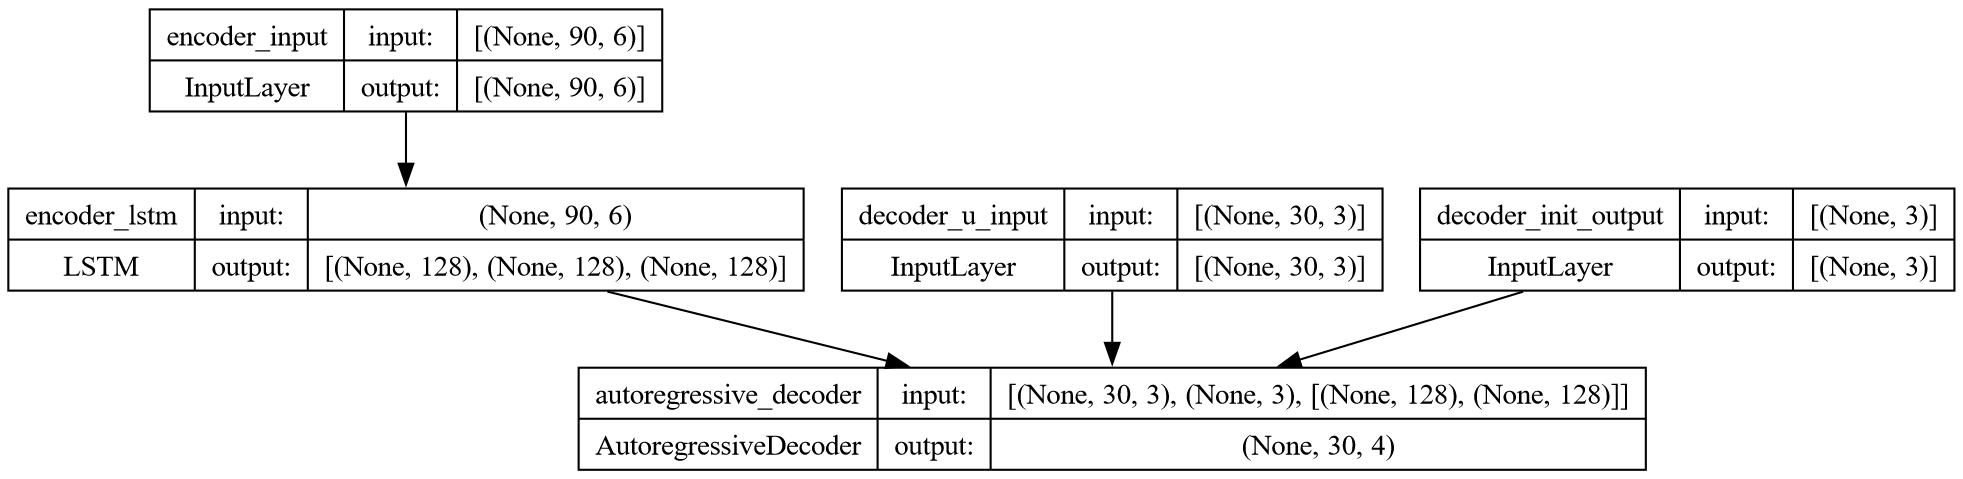

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Set the save path for the model plot
plot_path = FIG_DIR / "seq2seq_model_architecture.png"

# Plot and save the model architecture
plot_model(
    model,
    to_file=str(plot_path),
    show_shapes=True,
    show_layer_names=True,
    dpi=150
)
display(Image(filename=str(plot_path)))


## 6. 模型訓練

### 📈 6.1 模型架構總結

**模型規模**：
- Encoder LSTM: 128 units
- Decoder LSTM: 128 units
- 總參數量: ~208K parameters

**輸入輸出維度**：
- Encoder 輸入: (batch, 90, 6)
- Decoder MV 輸入: (batch, 30, 3)
- Decoder 初始值: (batch, 3)
- 模型輸出: (batch, 30, 4)

### 📊 6.2 Loss權重分配策略 - 設計指數遞減權重函數

**動機：不同時間步的預測重要性不同**

在多步預測中：
- **近期預測（t+1, t+2）**更重要：
  - 直接影響當前控制決策
  - 預測誤差較小、更可靠
  - 對MPC等控制策略最關鍵
  
- **遠期預測（t+29, t+30）**相對不太重要：
  - 預測誤差累積較大
  - 不確定性增加
  - 對當前決策影響較小

**🎯 時間權重的作用：**

$$\mathcal{L}_{weighted} = \sum_{t=1}^{H} w_t \cdot \|\mathbf{y}_t - \hat{\mathbf{y}}_t\|^2$$

其中

$$w_t = \frac{e^{-\lambda(t-1)}}{\sum_{i=1}^{H} e^{-\lambda(i-1)}}$$

**優點：**
1. **引導模型優先優化近期預測**
2. **更符合實際應用需求**（MPC只關注近期）
3. **提升整體控制性能**
4. **避免模型過度關注遠期不可靠預測**

**衰減率選擇建議：**
- $t \in [1, H]$ 是預測步數
- $\lambda$ 是衰減率（lambda），控制衰減速度
- $\lambda = 0$：均勻權重
- $\lambda = 0.05$：溫和衰減
- $\lambda = 0.1$：中等衰減
- $\lambda = 0.2$：快速衰減

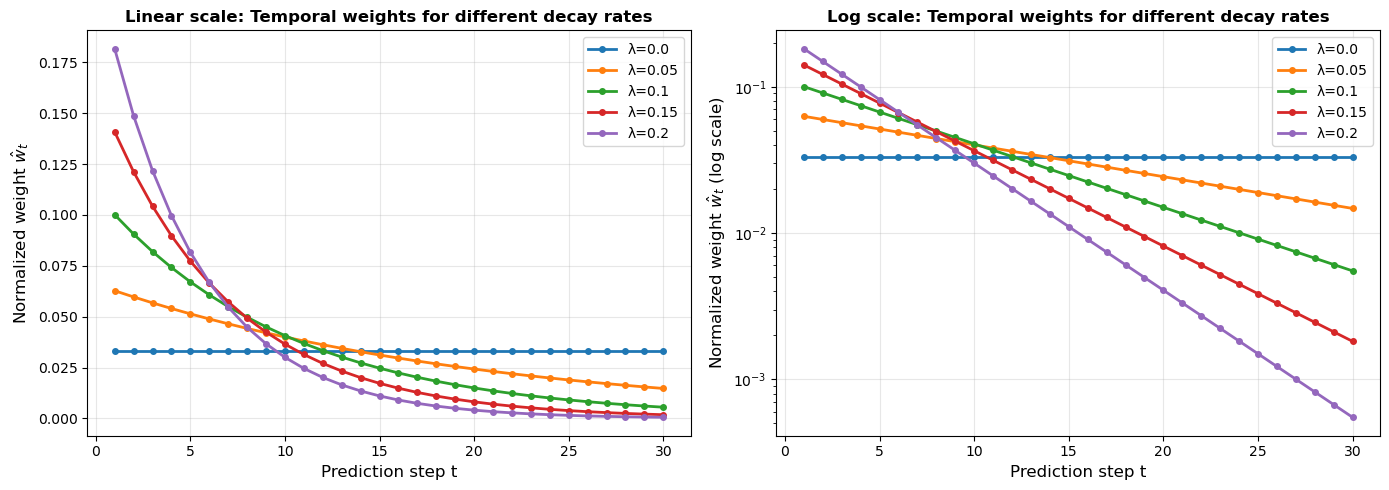


=== 不同衰減率的權重分佈（前10步）===

步數      λ=0.0   λ=0.05  λ=0.1   λ=0.15  λ=0.2   
------------------------------------------------------------
t=1     0.0333  0.0628  0.1001  0.1409  0.1817  
t=2     0.0333  0.0597  0.0906  0.1212  0.1488  
t=3     0.0333  0.0568  0.0820  0.1043  0.1218  
t=4     0.0333  0.0540  0.0742  0.0898  0.0997  
t=5     0.0333  0.0514  0.0671  0.0773  0.0817  
t=6     0.0333  0.0489  0.0607  0.0665  0.0669  
t=7     0.0333  0.0465  0.0550  0.0573  0.0547  
t=8     0.0333  0.0442  0.0497  0.0493  0.0448  
t=9     0.0333  0.0421  0.0450  0.0424  0.0367  
t=10    0.0333  0.0400  0.0407  0.0365  0.0300  

權重比值（第1步/第30步）：
λ=0.0: 1.00x
λ=0.05: 4.26x
λ=0.1: 18.17x
λ=0.15: 77.48x
λ=0.2: 330.30x


In [10]:
def create_temporal_weights(H, decay_rate=0.1, normalize=True):
    """
    創建時間步指數遞減權重
    
    參數:
        H: 預測長度（時間步數）
        decay_rate: 衰減率 λ (lambda)
            - 0: 均勻權重
            - 0.05: 溫和衰減
            - 0.1: 中等衰減 (預設)
            - 0.2: 快速衰減
        normalize: 是否歸一化權重（使權重和為1）
    
    返回:
        weights: shape (H,) 的權重數組
    """
    # 計算指數遞減權重: w_t = exp(-λ * (t-1))
    time_steps = np.arange(1, H + 1)
    weights = np.exp(-decay_rate * (time_steps - 1))
    
    # 歸一化（可選）
    if normalize:
        weights = weights / weights.sum()
    
    return weights

# 測試不同衰減率
H_test = 30
decay_rates = [0.0, 0.05, 0.1, 0.15, 0.2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for decay_rate in decay_rates:
    weights = create_temporal_weights(H_test, decay_rate, normalize=True)
    time_steps = np.arange(1, H_test + 1)
    
    ax1.plot(time_steps, weights, 'o-', label=f'λ={decay_rate}', linewidth=2, markersize=4)
    ax2.semilogy(time_steps, weights, 'o-', label=f'λ={decay_rate}', linewidth=2, markersize=4)

ax1.set_xlabel('Prediction step t', fontsize=12)
ax1.set_ylabel('Normalized weight $\\hat{w}_t$', fontsize=12)
ax1.set_title('Linear scale: Temporal weights for different decay rates', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.set_xlabel('Prediction step t', fontsize=12)
ax2.set_ylabel('Normalized weight $\\hat{w}_t$ (log scale)', fontsize=12)
ax2.set_title('Log scale: Temporal weights for different decay rates', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'temporal_weights_decay_rates.png', dpi=150, bbox_inches='tight')
plt.show()

# 顯示數值對比
print("\n=== 不同衰減率的權重分佈（前10步）===\n")
print(f"{'步數':<8}", end='')
for decay_rate in decay_rates:
    print(f"λ={decay_rate:<6}", end='')
print()
print('-' * 60)

for t in range(1, 11):
    print(f"t={t:<6}", end='')
    for decay_rate in decay_rates:
        weights = create_temporal_weights(H_test, decay_rate, normalize=True)
        print(f"{weights[t-1]:<8.4f}", end='')
    print()

print("\n權重比值（第1步/第30步）：")
for decay_rate in decay_rates:
    weights = create_temporal_weights(H_test, decay_rate, normalize=True)
    ratio = weights[0] / weights[-1]
    print(f"λ={decay_rate}: {ratio:.2f}x")

### 🎯 自回歸 Decoder 與 Scheduled Sampling 訓練策略

**自回歸 Decoder**
| 特性 | 自回歸版本（本版本）|
|------|-------------------|
| **輸入** | MV(t) + PV(t-1) |
| **訓練策略** | Scheduled Sampling |
| **推理方式** | 自回歸生成 |
| **優點** | 訓練-推理一致 |
| **缺點** | 訓練稍慢 |

**什麼是 Scheduled Sampling？**

在訓練 Seq2Seq 模型時，有兩種策略：

1. **Teacher Forcing**：訓練時總是使用真實值作為下一步輸入
   - 優點：訓練穩定、收斂快
   - 缺點：推理時使用預測值，導致 train-test mismatch

2. **Free Running**：訓練時總是使用預測值作為下一步輸入
   - 優點：訓練推理一致
   - 缺點：訓練不穩定、容易發散

3. **Scheduled Sampling**（折衷方案）：
   - 訓練初期：高機率使用真實值（teacher forcing）
   - 訓練後期：逐漸增加使用預測值的機率
   - 平滑過渡，兼具穩定性和一致性

**線性衰減策略**：

$$P_{teacher}(epoch) = \max(0, 1 - \frac{epoch}{decay\_epochs})$$

`decay_epochs`決定第幾個epochs之後完全採用Free Running

**自回歸結構的優勢**：
- ✅ 更符合實際推理情況（使用自己的預測值）
- ✅ 避免 exposure bias（訓練推理不一致問題）
- ✅ Scheduled Sampling 平滑過渡，穩定訓練

**Scheduled Sampling 時間表**：
- Epoch 1-20：主要使用真實值（teacher forcing ratio > 0.6）
- Epoch 21-50：逐漸增加預測值使用（ratio 線性衰減）
- Epoch 50+：完全使用預測值（ratio = 0）

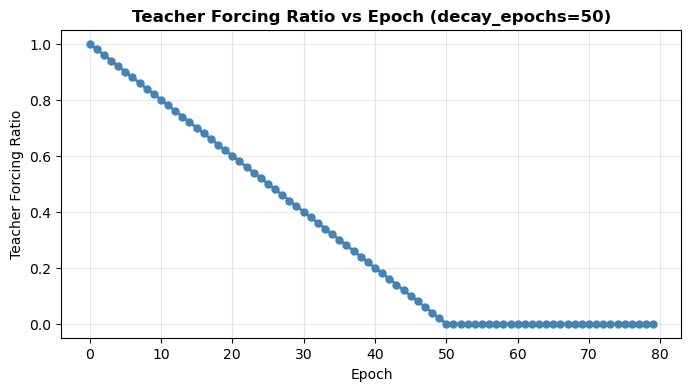

In [11]:
# 畫圖當 decay_epochs=50 時，teacher forcing ratio 隨 epoch 的變化
decay_epochs = 50
epochs = np.arange(0, 80)
tf_ratio = np.maximum(0.0, 1.0 - epochs / decay_epochs)

plt.figure(figsize=(8, 4))
plt.plot(epochs, tf_ratio, 'o-', linewidth=2, markersize=5, color='steelblue')
plt.title('Teacher Forcing Ratio vs Epoch (decay_epochs=50)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Teacher Forcing Ratio')
plt.grid(alpha=0.3)
plt.ylim([-0.05, 1.05])
plt.savefig(FIG_DIR / 'teacher_forcing_ratio.png', dpi=150, bbox_inches='tight')
plt.show()


In [12]:
class ScheduledSamplingTrainer:
    """
    自定義訓練器，實現 Scheduled Sampling 策略和時間衰減權重
    """
    def __init__(self, encoder_lstm, decoder_lstm, decoder_dense, 
                 encoder_steps, decoder_steps, 
                 decay_epochs=30,
                 temporal_decay_rate=0.1,
                 learning_rate=0.0005,
                 clip_norm=None,
                 feature_weights=None):
        """
        參數:
            temporal_decay_rate: 時間步權重的衰減率 λ
                - 0.0: 均勻權重（所有時間步同等重要）
                - 0.05: 溫和衰減
                - 0.1: 中等衰減（預設，推薦）
                - 0.15: 較快衰減
                - 0.2: 快速衰減
            feature_weights: 長度=輸出特徵數的權重向量（例如 [1, 1, 1, 2]）
        """
        self.encoder_lstm = encoder_lstm
        self.decoder_lstm = decoder_lstm
        self.decoder_dense = decoder_dense
        self.encoder_steps = encoder_steps
        self.decoder_steps = decoder_steps
        self.decay_epochs = decay_epochs
        self.clip_norm = clip_norm
        
        temporal_weights = create_temporal_weights(
            decoder_steps, 
            decay_rate=temporal_decay_rate, 
            normalize=True
        )
        self.temporal_weights = tf.constant(temporal_weights, dtype=tf.float32)
        if feature_weights is not None:
            feature_weights = tf.constant(feature_weights, dtype=tf.float32)
            self.feature_weights = tf.reshape(feature_weights, [1, 1, -1])
        else:
            self.feature_weights = None

        
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = keras.losses.MeanSquaredError(reduction='none')
        self.mae_fn = keras.metrics.MeanAbsoluteError()
    
    def get_teacher_forcing_ratio(self, epoch):
        """計算當前 epoch 的 teacher forcing 比率"""
        return max(0.0, 1.0 - epoch / self.decay_epochs)

    def _compute_weighted_loss(self, y_true, y_pred):
        err = tf.square(y_true - y_pred)
        if self.feature_weights is not None:
            err = err * self.feature_weights
        step_loss = tf.reduce_sum(err, axis=-1)
        weighted_step_loss = step_loss * self.temporal_weights
        return tf.reduce_mean(tf.reduce_sum(weighted_step_loss, axis=1))

    def _decode(self, x_dec_u, y_init, init_states, y_true, teacher_forcing_ratio):
        outputs = tf.TensorArray(tf.float32, size=self.decoder_steps)
        prev_y = y_init
        states = init_states
        batch_size = tf.shape(x_dec_u)[0]

        for t in tf.range(self.decoder_steps):
            u_t = x_dec_u[:, t, :]
            if t == 0:
                prev_y_use = prev_y
            else:
                use_tf = tf.random.uniform([batch_size, 1]) < teacher_forcing_ratio
                # 只取 y_true 的前3列用於自回歸（Y_CA, Y_T, Y_CB），不包含 G
                prev_y_use = tf.where(use_tf, y_true[:, t - 1, :3], prev_y)

            decoder_input_t = tf.concat([u_t, prev_y_use], axis=-1)
            decoder_input_t = tf.expand_dims(decoder_input_t, axis=1)

            lstm_out, h, c = self.decoder_lstm(decoder_input_t, initial_state=states)
            states = [h, c]

            y_t = self.decoder_dense(lstm_out)  # (batch, 4)
            y_t_expanded = tf.expand_dims(y_t, axis=1)  # (batch, 1, 4)
            outputs = outputs.write(t, y_t_expanded)
            # 只取前3個輸出值作為下一步的輸入
            prev_y = y_t[:, :3]

        return tf.transpose(outputs.stack(), [1, 0, 2, 3])[:, :, 0, :]

    @tf.function
    def train_step(self, x_enc, x_dec_u, y_init, y_true, teacher_forcing_ratio):
        x_enc = tf.cast(x_enc, tf.float32)
        x_dec_u = tf.cast(x_dec_u, tf.float32)
        y_init = tf.cast(y_init, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        with tf.GradientTape() as tape:
            _, state_h, state_c = self.encoder_lstm(x_enc)
            y_pred = self._decode(x_dec_u, y_init, [state_h, state_c], y_true, teacher_forcing_ratio)
            loss = self._compute_weighted_loss(y_true, y_pred)

        trainable_vars = (self.encoder_lstm.trainable_variables + 
                         self.decoder_lstm.trainable_variables + 
                         self.decoder_dense.trainable_variables)
        gradients = tape.gradient(loss, trainable_vars)
        if self.clip_norm is not None:
            gradients = [
                tf.clip_by_norm(grad, self.clip_norm) if grad is not None else None
                for grad in gradients
            ]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        mae = tf.reduce_mean(tf.abs(y_true - y_pred))
        return loss, mae

    @tf.function
    def val_step(self, x_enc, x_dec_u, y_init, y_true):
        x_enc = tf.cast(x_enc, tf.float32)
        x_dec_u = tf.cast(x_dec_u, tf.float32)
        y_init = tf.cast(y_init, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        _, state_h, state_c = self.encoder_lstm(x_enc)
        y_pred = self._decode(x_dec_u, y_init, [state_h, state_c], y_true, 0.0)
        loss = self._compute_weighted_loss(y_true, y_pred)
        mae = tf.reduce_mean(tf.abs(y_true - y_pred))
        return loss, mae

    def train(self, X_enc_train, X_dec_u_train, y_init_train, y_train,
              X_enc_val, X_dec_u_val, y_init_val, y_val,
              epochs=100, batch_size=64, patience=30, verbose=1):
        """
        訓練模型
        
        參數：
            patience: Early Stopping的耐心值，建議設置為30以適應Scheduled Sampling的過渡期
        """
        n_train = X_enc_train.shape[0]
        n_val = X_enc_val.shape[0]
        
        history = {
            'loss': [], 'mae': [], 'val_loss': [], 'val_mae': [],
            'teacher_forcing_ratio': []
        }
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_weights = None

        train_ds = tf.data.Dataset.from_tensor_slices(
            (X_enc_train, X_dec_u_train, y_init_train, y_train)
        ).shuffle(n_train, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (X_enc_val, X_dec_u_val, y_init_val, y_val)
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        for epoch in range(epochs):
            tf_ratio = self.get_teacher_forcing_ratio(epoch)
            history['teacher_forcing_ratio'].append(tf_ratio)

            train_loss = keras.metrics.Mean()
            train_mae = keras.metrics.Mean()

            for x_enc_b, x_dec_u_b, y_init_b, y_b in train_ds:
                loss, mae = self.train_step(
                    x_enc_b, x_dec_u_b, y_init_b, y_b, tf.constant(tf_ratio, dtype=tf.float32)
                )
                train_loss.update_state(loss)
                train_mae.update_state(mae)

            val_loss = keras.metrics.Mean()
            val_mae = keras.metrics.Mean()

            for x_enc_b, x_dec_u_b, y_init_b, y_b in val_ds:
                loss, mae = self.val_step(x_enc_b, x_dec_u_b, y_init_b, y_b)
                val_loss.update_state(loss)
                val_mae.update_state(mae)

            avg_loss = float(train_loss.result().numpy())
            avg_mae = float(train_mae.result().numpy())
            avg_val_loss = float(val_loss.result().numpy())
            avg_val_mae = float(val_mae.result().numpy())

            history['loss'].append(avg_loss)
            history['mae'].append(avg_mae)
            history['val_loss'].append(avg_val_loss)
            history['val_mae'].append(avg_val_mae)

            if avg_val_loss < best_val_loss:
                best_weights = (
                    self.encoder_lstm.get_weights(),
                    self.decoder_lstm.get_weights(),
                    self.decoder_dense.get_weights()
                )
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if verbose:
                print(
                    f"Epoch {epoch+1}/{epochs} - TF_ratio: {tf_ratio:.3f} - "
                    f"loss: {avg_loss:.4f} - mae: {avg_mae:.4f} - "
                    f"val_loss: {avg_val_loss:.4f} - val_mae: {avg_val_mae:.4f}"
                )

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if best_weights is not None:
            self.encoder_lstm.set_weights(best_weights[0])
            self.decoder_lstm.set_weights(best_weights[1])
            self.decoder_dense.set_weights(best_weights[2])

        return history

print("✅ Scheduled Sampling 訓練器已建立")


✅ Scheduled Sampling 訓練器已建立


#### 開始訓練

In [13]:
# 建立訓練器（使用時間衰減權重）
trainer = ScheduledSamplingTrainer(
    encoder_lstm=encoder_lstm,
    decoder_lstm=decoder_lstm,
    decoder_dense=decoder_dense,
    encoder_steps=W,
    decoder_steps=H,
    decay_epochs=50,  # 50 個 epoch 後完全切換到預測值
    temporal_decay_rate=0.1  # 時間權重衰減率（0.1表示中等衰減）
    #feature_weights=[1.0, 1.0, 1.0, 2.0]  # 品質變數 G 權重加倍
)

print(f"✅ 訓練器已建立")
print(f"   - Scheduled Sampling: {trainer.decay_epochs} epochs 衰減")
print(f"   - 時間權重衰減率 λ = {0.1}")
print(f"   - 第1步權重 / 第{H}步權重 = {trainer.temporal_weights[0].numpy():.4f} / {trainer.temporal_weights[-1].numpy():.4f}")
print(f"   - 權重比值: {(trainer.temporal_weights[0]/trainer.temporal_weights[-1]).numpy():.2f}x")

# 訓練模型
print("開始訓練 Seq2Seq 模型（使用 Scheduled Sampling）...")
history_dict = trainer.train(
    X_enc_train, X_dec_u_train, y_init_train, y_train,
    X_enc_val, X_dec_u_val, y_init_val, y_val,
    epochs=200,
    batch_size=32,
    patience=20,
    verbose=1
)

# 轉換為 keras History 格式以便後續使用
class HistoryWrapper:
    def __init__(self, history_dict):
        self.history = history_dict

history = HistoryWrapper(history_dict)

✅ 訓練器已建立
   - Scheduled Sampling: 50 epochs 衰減
   - 時間權重衰減率 λ = 0.1
   - 第1步權重 / 第30步權重 = 0.1001 / 0.0055
   - 權重比值: 18.17x
開始訓練 Seq2Seq 模型（使用 Scheduled Sampling）...
Epoch 1/200 - TF_ratio: 1.000 - loss: 0.2724 - mae: 0.1217 - val_loss: 0.0100 - val_mae: 0.0353
Epoch 2/200 - TF_ratio: 0.980 - loss: 0.0110 - mae: 0.0217 - val_loss: 0.0058 - val_mae: 0.0211
Epoch 3/200 - TF_ratio: 0.960 - loss: 0.0072 - mae: 0.0181 - val_loss: 0.0037 - val_mae: 0.0168
Epoch 4/200 - TF_ratio: 0.940 - loss: 0.0051 - mae: 0.0160 - val_loss: 0.0031 - val_mae: 0.0168
Epoch 5/200 - TF_ratio: 0.920 - loss: 0.0038 - mae: 0.0147 - val_loss: 0.0030 - val_mae: 0.0160
Epoch 6/200 - TF_ratio: 0.900 - loss: 0.0033 - mae: 0.0146 - val_loss: 0.0024 - val_mae: 0.0148
Epoch 7/200 - TF_ratio: 0.880 - loss: 0.0029 - mae: 0.0143 - val_loss: 0.0027 - val_mae: 0.0192
Epoch 8/200 - TF_ratio: 0.860 - loss: 0.0025 - mae: 0.0134 - val_loss: 0.0018 - val_mae: 0.0131
Epoch 9/200 - TF_ratio: 0.840 - loss: 0.0025 - mae: 0.0141 - val_l

### 6.3 訓練診斷分析

In [14]:
# 🔍 訓練診斷分析
print("\n" + "="*80)
print("📊 訓練過程診斷")
print("="*80)

# 找出最佳epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = np.min(history.history['val_loss'])
final_train_loss = history.history['loss'][best_epoch-1]

print(f"\n最佳 Epoch: {best_epoch}")
print(f"  訓練集 Loss: {final_train_loss:.4f}")
print(f"  驗證集 Loss: {best_val_loss:.4f}")
print(f"  過擬合程度: {(best_val_loss/final_train_loss - 1)*100:.1f}%")

# 判斷訓練狀態
if best_val_loss / final_train_loss < 1.1:
    print("  ✅ 訓練良好：訓練集和驗證集loss接近")
elif best_val_loss / final_train_loss < 1.2:
    print("  ⚠️ 輕微過擬合：可接受範圍")
else:
    print("  ❌ 過擬合：驗證集loss明顯高於訓練集")

# 檢查收斂性
total_epochs = len(history.history['loss'])
if total_epochs < 20:
    print(f"\n⚠️ 訓練過早停止（僅{total_epochs}個epoch）")
    print("   建議：增加early stopping的patience參數")
elif total_epochs >= 100:
    print(f"\n⚠️ 未收斂：達到最大epoch限制（{total_epochs}）")
    print("   建議：增加max epochs或調整學習率")
else:
    print(f"\n✅ 訓練正常：共{total_epochs}個epoch，在合理範圍內")

print("="*80)


📊 訓練過程診斷

最佳 Epoch: 116
  訓練集 Loss: 0.0008
  驗證集 Loss: 0.0007
  過擬合程度: -9.7%
  ✅ 訓練良好：訓練集和驗證集loss接近

⚠️ 未收斂：達到最大epoch限制（136）
   建議：增加max epochs或調整學習率


### 6.4 訓練曲線可視化

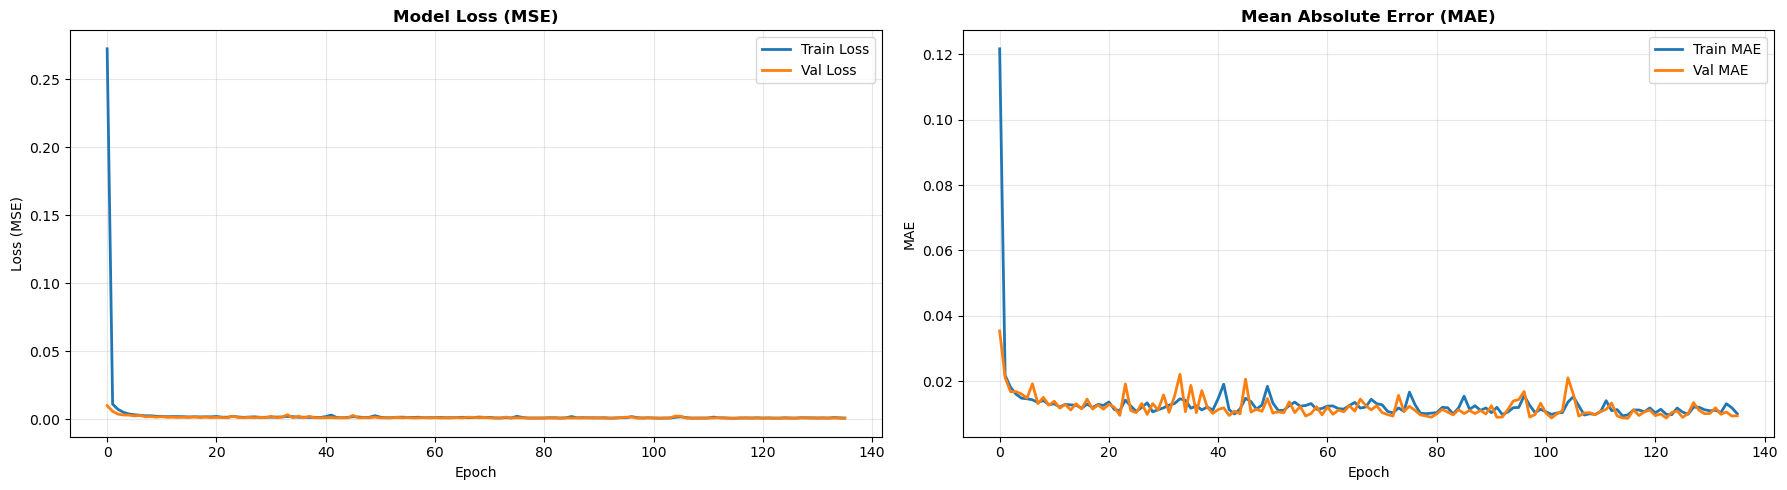

In [15]:
# 繪製訓練曲線
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_title('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. 模型評估與預測

所有變數的 R² 均達到 0.999 以上，表示模型對 CSTR 系統的多步預測能力優秀。

### 🎯 測試集整體表現

- **G (品質指標)**：RMSE=0.24, R²=1.0000 ✅

**各變數評估指標**：- **C_B (產物濃度)**：RMSE=0.44, R²=0.9994 ✅

- **C_A (反應物濃度)**：RMSE=1.00, R²=1.0000 ✅- **T (反應器溫度)**：RMSE=0.09, R²=0.9994 ✅

In [16]:
# 🔥 對所有數據集進行預測（訓練集、驗證集、測試集）

# 訓練集預測
print("預測訓練集...")
y_train_pred = model.predict([X_enc_train, X_dec_u_train, y_init_train])
print(f"訓練集預測形狀: {y_train_pred.shape}")

# 驗證集預測
print("預測驗證集...")
y_val_pred = model.predict([X_enc_val, X_dec_u_val, y_init_val])
print(f"驗證集預測形狀: {y_val_pred.shape}")

# 測試集預測
print("預測測試集...")
y_pred_test = model.predict([X_enc_test, X_dec_u_test, y_init_test])
print(f"測試集預測形狀: {y_pred_test.shape}")

# ===== 反標準化所有數據集 =====

# 訓練集反標準化
y_train_orig = np.zeros_like(y_train)
y_train_pred_orig = np.zeros_like(y_train_pred)

# Y (前3個特徵)
y_train_orig[:, :, :3] = scalers['Y'].inverse_transform(
    y_train[:, :, :3].reshape(-1, 3)
).reshape(y_train.shape[0], y_train.shape[1], 3)
y_train_pred_orig[:, :, :3] = scalers['Y'].inverse_transform(
    y_train_pred[:, :, :3].reshape(-1, 3)
).reshape(y_train_pred.shape[0], y_train_pred.shape[1], 3)

# Q (最後1個特徵)
y_train_orig[:, :, 3:] = scalers['Q'].inverse_transform(
    y_train[:, :, 3:].reshape(-1, 1)
).reshape(y_train.shape[0], y_train.shape[1], 1)
y_train_pred_orig[:, :, 3:] = scalers['Q'].inverse_transform(
    y_train_pred[:, :, 3:].reshape(-1, 1)
).reshape(y_train_pred.shape[0], y_train_pred.shape[1], 1)

# 驗證集反標準化
y_val_orig = np.zeros_like(y_val)
y_val_pred_orig = np.zeros_like(y_val_pred)

# Y (前3個特徵)
y_val_orig[:, :, :3] = scalers['Y'].inverse_transform(
    y_val[:, :, :3].reshape(-1, 3)
).reshape(y_val.shape[0], y_val.shape[1], 3)
y_val_pred_orig[:, :, :3] = scalers['Y'].inverse_transform(
    y_val_pred[:, :, :3].reshape(-1, 3)
).reshape(y_val_pred.shape[0], y_val_pred.shape[1], 3)

# Q (最後1個特徵)
y_val_orig[:, :, 3:] = scalers['Q'].inverse_transform(
    y_val[:, :, 3:].reshape(-1, 1)
).reshape(y_val.shape[0], y_val.shape[1], 1)
y_val_pred_orig[:, :, 3:] = scalers['Q'].inverse_transform(
    y_val_pred[:, :, 3:].reshape(-1, 1)
).reshape(y_val_pred.shape[0], y_val_pred.shape[1], 1)

# 測試集反標準化
y_test_orig = np.zeros_like(y_test)
y_pred_orig = np.zeros_like(y_pred_test)

# Y (前3個特徵)
y_test_orig[:, :, :3] = scalers['Y'].inverse_transform(
    y_test[:, :, :3].reshape(-1, 3)
).reshape(y_test.shape[0], y_test.shape[1], 3)
y_pred_orig[:, :, :3] = scalers['Y'].inverse_transform(
    y_pred_test[:, :, :3].reshape(-1, 3)
).reshape(y_pred_test.shape[0], y_pred_test.shape[1], 3)

# Q (最後1個特徵)
y_test_orig[:, :, 3:] = scalers['Q'].inverse_transform(
    y_test[:, :, 3:].reshape(-1, 1)
).reshape(y_test.shape[0], y_test.shape[1], 1)
y_pred_orig[:, :, 3:] = scalers['Q'].inverse_transform(
    y_pred_test[:, :, 3:].reshape(-1, 1)
).reshape(y_pred_test.shape[0], y_pred_test.shape[1], 1)

print("\n✅ 所有數據集預測完成並反標準化")

# 計算各變數的評估指標（測試集）
output_names = ['C_A', 'T', 'C_B', 'G']

print("\n=== 測試集評估指標（各變數）===")
for i, name in enumerate(output_names):
    y_true_i = y_test_orig[:, :, i].flatten()
    y_pred_i = y_pred_orig[:, :, i].flatten()
    
    mse = mean_squared_error(y_true_i, y_pred_i)
    mae = mean_absolute_error(y_true_i, y_pred_i)
    r2 = r2_score(y_true_i, y_pred_i)
    
    print(f"{name:8s} | MSE: {mse:8.2f} | MAE: {mae:6.2f} | R²: {r2:6.4f}")

預測訓練集...
131/131 [==============================] - 13s 29ms/step
訓練集預測形狀: (4191, 30, 4)
預測驗證集...
29/29 [==============================] - 1s 29ms/step
驗證集預測形狀: (898, 30, 4)
預測測試集...
29/29 [==============================] - 1s 29ms/step
測試集預測形狀: (899, 30, 4)

✅ 所有數據集預測完成並反標準化

=== 測試集評估指標（各變數）===
C_A      | MSE:     2.03 | MAE:   1.00 | R²: 1.0000
T        | MSE:     0.01 | MAE:   0.09 | R²: 0.9994
C_B      | MSE:     0.30 | MAE:   0.44 | R²: 0.9994
G        | MSE:     0.12 | MAE:   0.24 | R²: 1.0000


### 7.1 多步預測軌跡視覺化

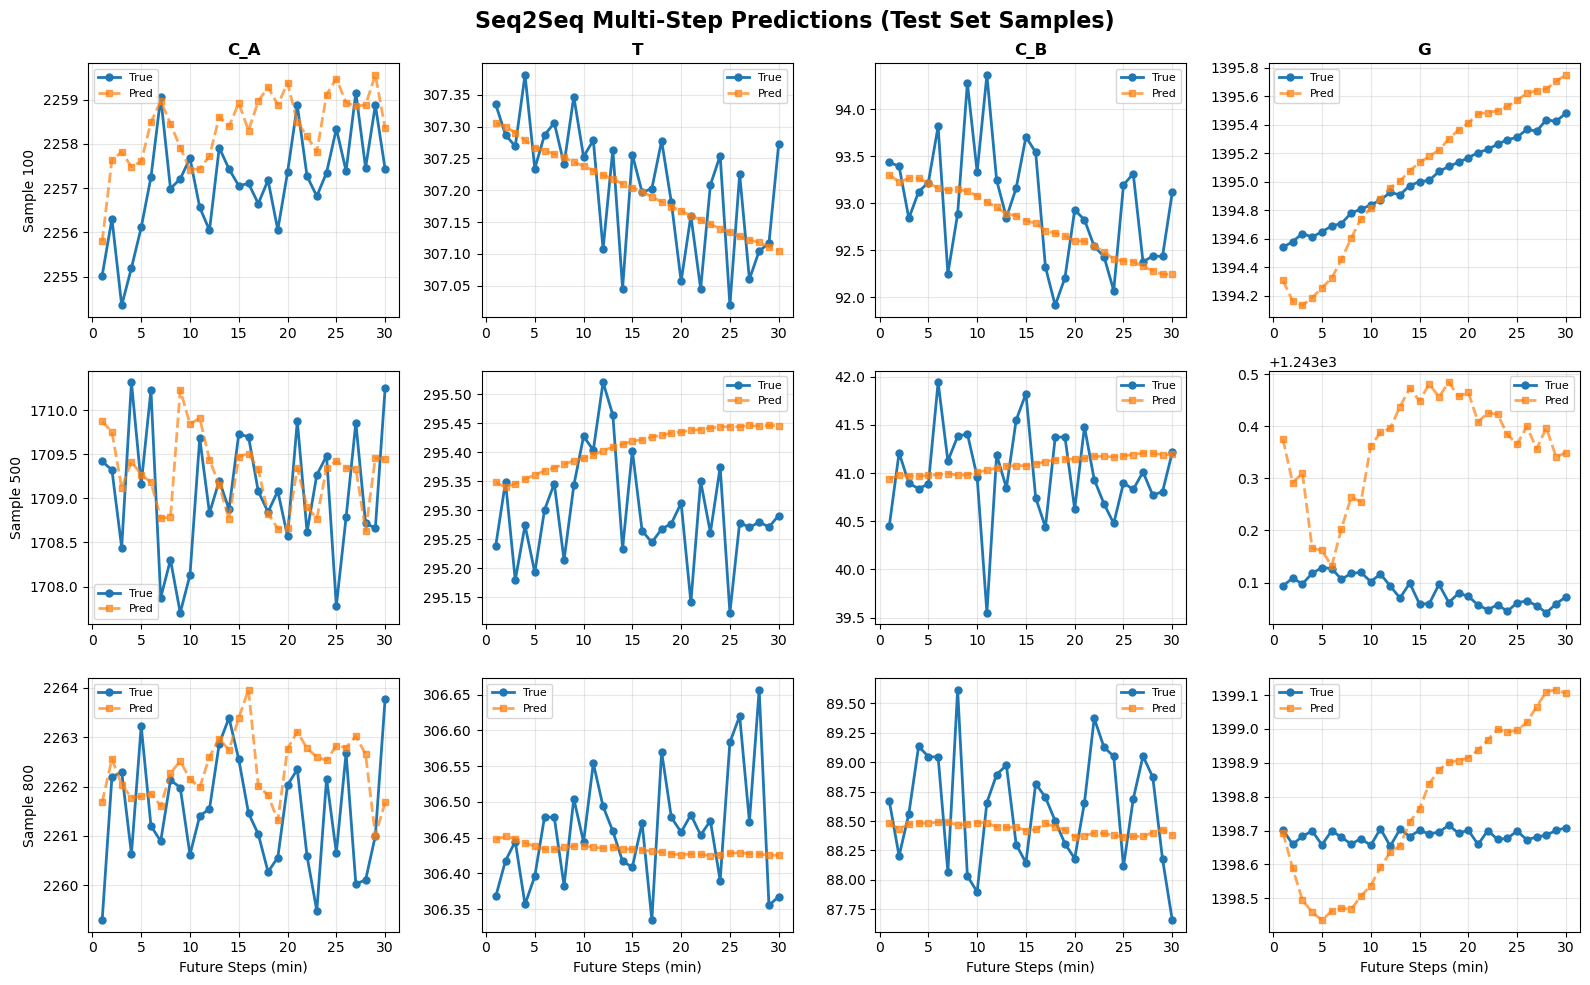

In [17]:
# 選擇 3 個測試樣本進行視覺化
sample_indices = [100, 500, 800]

fig, axes = plt.subplots(len(sample_indices), 4, figsize=(16, 10))
fig.suptitle('Seq2Seq Multi-Step Predictions (Test Set Samples)', fontsize=16, fontweight='bold')

for row_idx, sample_idx in enumerate(sample_indices):
    y_true_sample = y_test_orig[sample_idx]  # (H, 4)
    y_pred_sample = y_pred_orig[sample_idx]
    
    time_steps = np.arange(1, H+1)  # Future 1 ~ H steps
    
    for col_idx, var_name in enumerate(output_names):
        ax = axes[row_idx, col_idx]
        
        ax.plot(time_steps, y_true_sample[:, col_idx], 'o-', 
                label='True', linewidth=2, markersize=5)
        ax.plot(time_steps, y_pred_sample[:, col_idx], 's--', 
                label='Pred', linewidth=2, markersize=5, alpha=0.7)
        
        if row_idx == 0:
            ax.set_title(var_name, fontweight='bold')
        if row_idx == len(sample_indices) - 1:
            ax.set_xlabel('Future Steps (min)')
        if col_idx == 0:
            ax.set_ylabel(f'Sample {sample_idx}')
        
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(FIG_DIR / 'seq2seq_multi_step_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

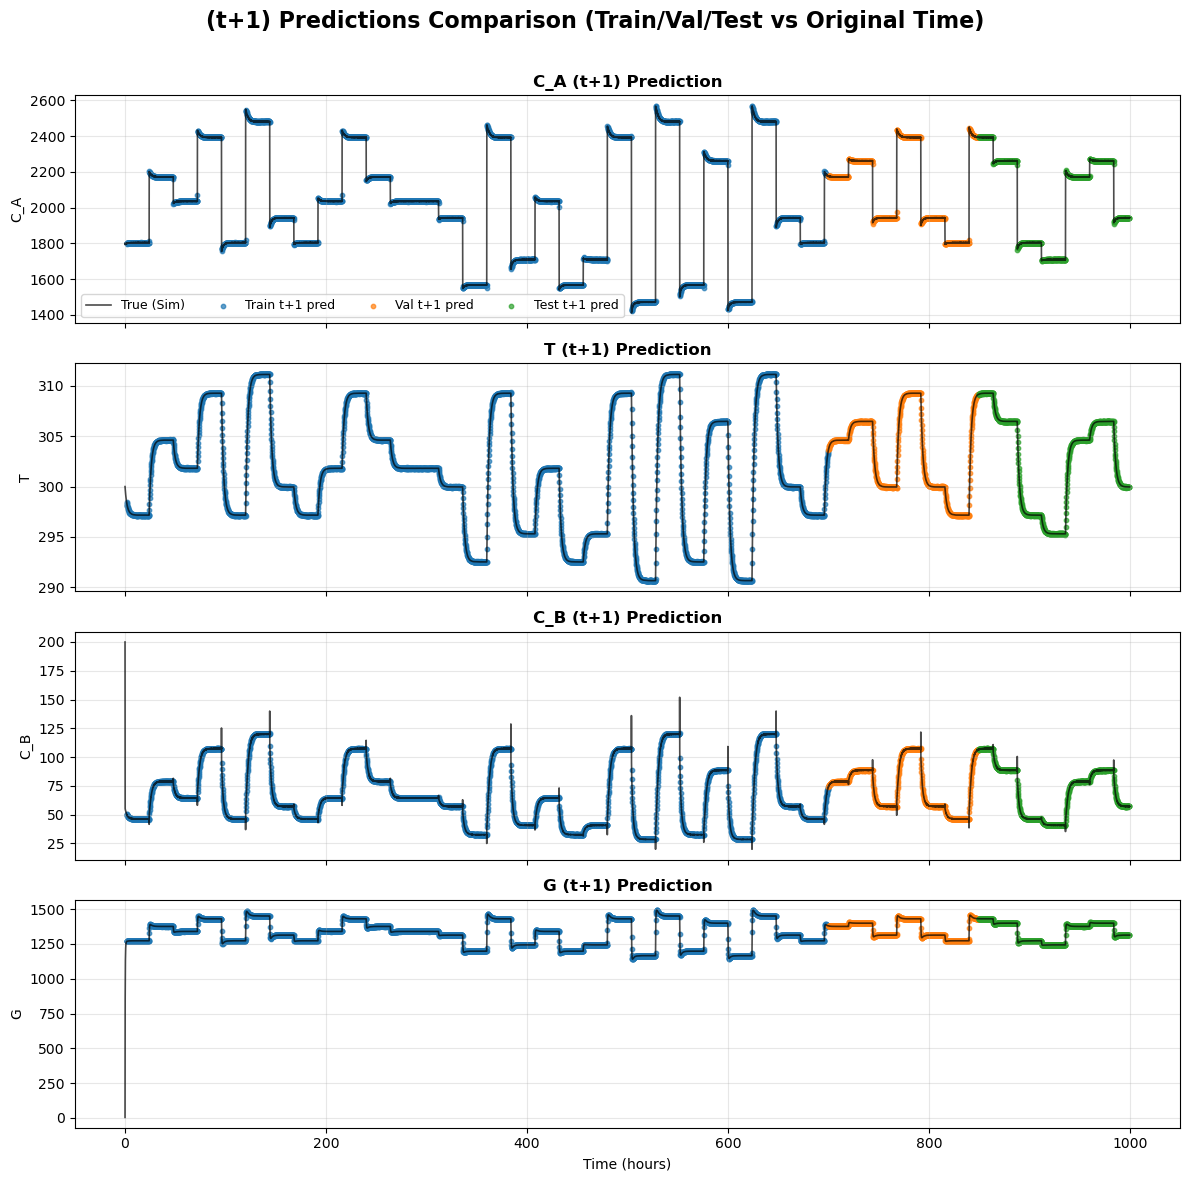

In [18]:
# 取得原始時間序列
time_full = df_sim['time_hour'].values

# 取得每個樣本的 t+1 在原始數據中的對應時間index
def get_sample_indices(total_len, encoder_steps, decoder_steps, shift):
    # 對應 create_seq2seq_dataset 的滑動窗口邏輯
    indices = []
    for i in range(encoder_steps, total_len - decoder_steps, shift):
        indices.append(i)
    return np.array(indices)

sample_indices_train = get_sample_indices(len(df_sim), W, H, shift)[:len(y_train)]
sample_indices_val = get_sample_indices(len(df_sim), W, H, shift)[len(y_train):len(y_train)+len(y_val)]
sample_indices_test = get_sample_indices(len(df_sim), W, H, shift)[len(y_train)+len(y_val):]

# 取原始真實值
var_names = ['C_A', 'T', 'C_B', 'G']
true_vars = [
    df_sim['Y_CA_true'].values,
    df_sim['Y_T_true'].values,
    df_sim['Y_CB_true'].values,
    df_sim['G'].values
]

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
fig.suptitle('(t+1) Predictions Comparison (Train/Val/Test vs Original Time)', fontsize=16, fontweight='bold')

for i, var in enumerate(var_names):
    ax = axes[i]
    # Plot original true values
    ax.plot(time_full, true_vars[i], color='black', label='True (Sim)', linewidth=1.2, alpha=0.7)
    # Plot t+1 prediction points
    ax.scatter(time_full[sample_indices_train], y_train_pred_orig[:, 0, i], color='tab:blue', s=10, label='Train t+1 pred', alpha=0.7)
    ax.scatter(time_full[sample_indices_val], y_val_pred_orig[:, 0, i], color='tab:orange', s=10, label='Val t+1 pred', alpha=0.7)
    ax.scatter(time_full[sample_indices_test], y_pred_orig[:, 0, i], color='tab:green', s=10, label='Test t+1 pred', alpha=0.7)
    ax.set_ylabel(var)
    ax.set_title(f"{var} (t+1) Prediction", fontweight='bold')
    ax.grid(alpha=0.3)
    if i == 0:
        ax.legend(ncol=4, fontsize=9)
axes[-1].set_xlabel('Time (hours)')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(FIG_DIR / 't_plus_1_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

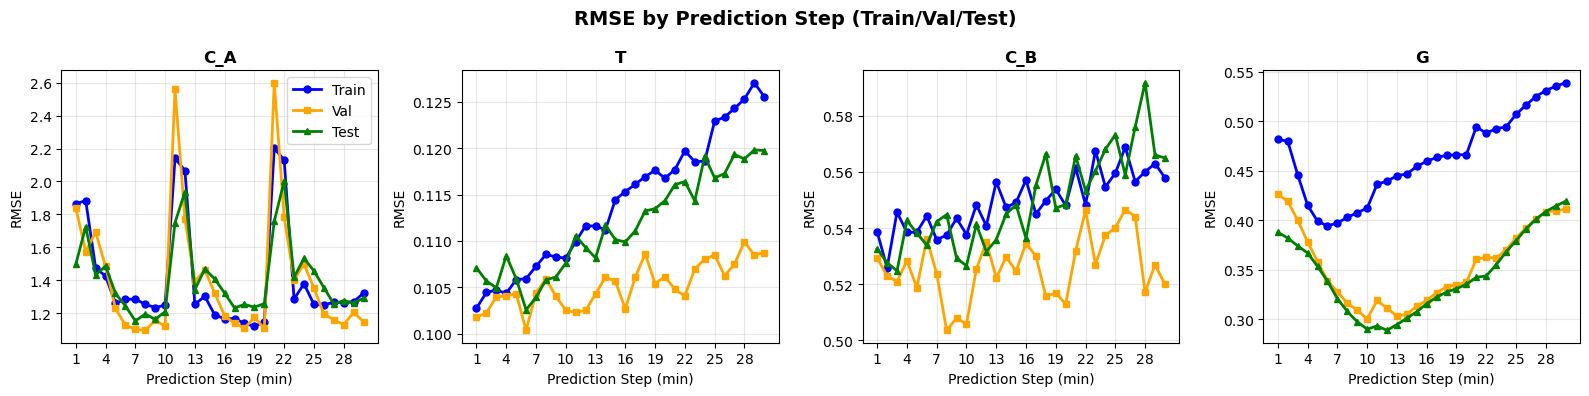

In [19]:
from sklearn.metrics import mean_squared_error

# 計算每個變數、每個時間步的 RMSE
def calc_step_rmse(y_true, y_pred, H):
    step_rmse = np.zeros((H, y_true.shape[2]))
    for step in range(H):
        for var_idx in range(y_true.shape[2]):
            y_true_step = y_true[:, step, var_idx]
            y_pred_step = y_pred[:, step, var_idx]
            step_rmse[step, var_idx] = np.sqrt(mean_squared_error(y_true_step, y_pred_step))
    return step_rmse

rmse_train = calc_step_rmse(y_train_orig, y_train_pred_orig, H)
rmse_val = calc_step_rmse(y_val_orig, y_val_pred_orig, H)
rmse_test = calc_step_rmse(y_test_orig, y_pred_orig, H)

# Plot RMSE for each prediction step
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('RMSE by Prediction Step (Train/Val/Test)', fontsize=14, fontweight='bold')

for var_idx, var_name in enumerate(output_names):
    axes[var_idx].plot(range(1, H+1), rmse_train[:, var_idx], 'b-o', label='Train', linewidth=2, markersize=5)
    axes[var_idx].plot(range(1, H+1), rmse_val[:, var_idx], 'orange', marker='s', label='Val', linewidth=2, markersize=5)
    axes[var_idx].plot(range(1, H+1), rmse_test[:, var_idx], 'g-^', label='Test', linewidth=2, markersize=5)
    axes[var_idx].set_title(var_name, fontweight='bold')
    axes[var_idx].set_xlabel('Prediction Step (min)')
    axes[var_idx].set_ylabel('RMSE')
    axes[var_idx].grid(alpha=0.3)
    axes[var_idx].set_xticks(range(1, H+1, max(1, H//10)))
    if var_idx == 0:
        axes[var_idx].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'rmse_by_prediction_step.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.3 散點圖與殘差分析

透過散點圖與殘差分布，驗證預測值與真實值的一致性，以及殘差是否符合零均值常態分布。

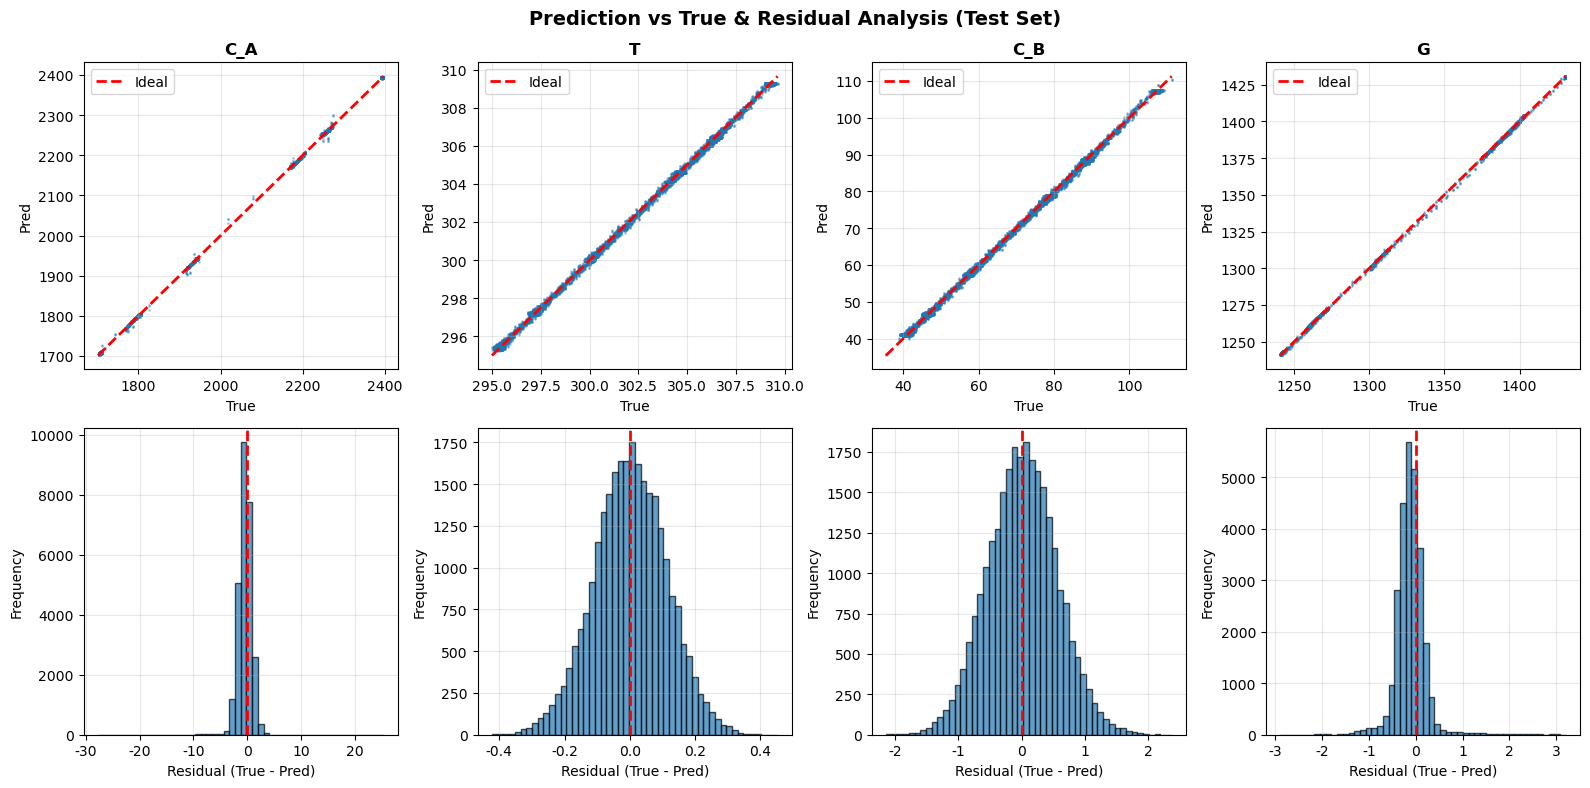

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Prediction vs True & Residual Analysis (Test Set)', fontsize=14, fontweight='bold')

for var_idx, var_name in enumerate(output_names):
    y_true_flat = y_test_orig[:, :, var_idx].flatten()
    y_pred_flat = y_pred_orig[:, :, var_idx].flatten()
    residuals = y_true_flat - y_pred_flat
    
    # Top: Scatter plot
    ax1 = axes[0, var_idx]
    ax1.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=1)
    
    # Ideal line
    min_val = min(y_true_flat.min(), y_pred_flat.min())
    max_val = max(y_true_flat.max(), y_pred_flat.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal')
    
    ax1.set_title(var_name, fontweight='bold')
    ax1.set_xlabel('True')
    ax1.set_ylabel('Pred')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Bottom: Residual distribution
    ax2 = axes[1, var_idx]
    ax2.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='r', linestyle='--', linewidth=2)
    ax2.set_xlabel('Residual (True - Pred)')
    ax2.set_ylabel('Frequency')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'scatter_and_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def make_metrics_table(y_true, y_pred, H, output_names, set_name):
    # y_true, y_pred: (n_samples, H, n_vars)
    n_vars = len(output_names)
    rmse_table = np.zeros((H, n_vars))
    r2_table = np.zeros((H, n_vars))
    for t in range(H):
        for v in range(n_vars):
            y_true_t = y_true[:, t, v]
            y_pred_t = y_pred[:, t, v]
            rmse_table[t, v] = calc_rmse(y_true_t, y_pred_t)
            r2_table[t, v] = r2_score(y_true_t, y_pred_t)
    # 只顯示 G 指標 (第4個變數, index=3)
    rmse_row = rmse_table[:, 3]
    r2_row = r2_table[:, 3]
    # 建立 DataFrame
    df = pd.DataFrame(
        [rmse_row, r2_row],
        index=['RMSE', 'R²'],
        columns=[f't+{i+1}' for i in range(H)]
    )
    return df

# 訓練集
metrics_train = make_metrics_table(y_train_orig, y_train_pred_orig, H, output_names, "訓練集")
print(f"\n【訓練集】G 指標多步預測表")
display(metrics_train.round(3))
# 驗證集
metrics_val = make_metrics_table(y_val_orig, y_val_pred_orig, H, output_names, "驗證集")
print(f"\n【驗證集】G 指標多步預測表")  
display(metrics_val.round(3))
# 測試集
metrics_test = make_metrics_table(y_test_orig, y_pred_orig, H, output_names, "測試集")
print(f"\n【測試集】G 指標多步預測表")
display(metrics_test.round(3))


【訓練集】G 指標多步預測表


,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,...,t+21,t+22,t+23,t+24,t+25,t+26,t+27,t+28,t+29,t+30
RMSE,0.482,0.48,0.446,0.415,0.399,0.394,0.397,0.403,0.408,0.412,...,0.495,0.488,0.493,0.494,0.507,0.516,0.525,0.531,0.535,0.539
R²,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000



【驗證集】G 指標多步預測表


,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,...,t+21,t+22,t+23,t+24,t+25,t+26,t+27,t+28,t+29,t+30
RMSE,0.427,0.419,0.4,0.378,0.358,0.339,0.328,0.316,0.309,0.301,...,0.361,0.363,0.362,0.37,0.382,0.392,0.402,0.408,0.41,0.411
R²,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.00,1.000



【測試集】G 指標多步預測表


,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,...,t+21,t+22,t+23,t+24,t+25,t+26,t+27,t+28,t+29,t+30
RMSE,0.388,0.382,0.374,0.367,0.354,0.339,0.321,0.308,0.298,0.29,...,0.343,0.344,0.355,0.368,0.38,0.391,0.401,0.409,0.414,0.419
R²,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.00,...,1.000,1.000,1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.000


In [22]:
K.clear_session()